In [58]:
import pandas as pd
import numpy as np
import datetime as dt
from importlib import reload
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('ggplot')
%matplotlib inline

import TSManager as ts

In [59]:
reload(ts)
mgr = ts.TSManager()
mgr.load()

Loading DP
Loading PE
Loading BM
Loading CAPE
Loading BY
Loading DEF
Loading PCAPrice
Loading CPI
Loading NOS
Loading PCR
Loading OIL
Loading SI
Loading BDI
Loading CAY
Loading IC
Loading TERM
Loading VRP
Loading SPX
Loading MA


In [60]:
df = mgr.data

x_cols = [x for x in df.columns if x not in ['SPX','RF']]
df.head()

,DP,PE,BM,CAPE,BY,DEF,PCAPrice,CPI,NOS,PCR,OIL,SI,BDI,CAY,IC,TERM,VRP,SPX,MA
AsOfDate,,,,,,,,,,,,,,,,,,,
1990-06-08,0.063979,7.524271,NaN,8.978524,1.007418,0.96,3.616905,0.046737,0.016941,-1.622923,NaN,NaN,1278.0,-0.013576,NaN,0.50,7.197727,-0.012302,1
1990-06-11,0.063463,7.597792,NaN,9.051612,1.009642,0.96,3.583706,0.046737,0.016941,-1.615366,NaN,NaN,1264.0,-0.013576,NaN,0.49,5.607431,0.008107,1
1990-06-12,0.062662,7.699009,NaN,9.167251,1.009580,0.96,3.532720,0.046737,0.016941,-1.618868,NaN,NaN,1254.0,-0.013576,NaN,0.49,6.403252,0.012695,1
1990-06-13,0.062894,7.674771,NaN,9.133460,1.000056,0.96,3.547245,0.046737,0.016941,-1.625316,NaN,NaN,1243.0,-0.013576,NaN,0.47,7.793147,-0.003693,1
1990-06-14,0.063241,7.636994,NaN,9.083400,0.997689,0.96,3.569002,0.046737,0.016941,-1.620454,NaN,NaN,1232.0,-0.013576,NaN,0.46,7.665179,-0.005496,1


In [78]:
df['SPX']

AsOfDate
1990-06-08   -0.012302
1990-06-11    0.008107
1990-06-12    0.012695
1990-06-13   -0.003693
1990-06-14   -0.005496
                ...   
2019-03-21    0.010794
2019-03-22   -0.019157
2019-03-25   -0.000839
2019-03-26    0.007157
2019-03-27   -0.004655
Name: SPX, Length: 7256, dtype: float64

In [79]:
df_raw = pd.read_csv('raw_data/spx/SP500_prices.csv')

In [61]:
df.shape

(7411, 19)

In [62]:
# how many years of SPX data do we have?
(df['SPX'].dropna().shape[0] - 130) / 252

28.78968253968254

In [63]:
# constructing the target label
df['spx_tp130'] = df['SPX'].rolling(130).sum().shift(-129)
df = df.dropna(subset=['spx_tp130'])

## Program Parameters

In [64]:
LOOKBACK_YEARS = 10  # when regressing, how far back to look in years
VALIDATE_DAYS = 20  # when regressing, the number of days to hold parameters constant
MIN_X_THRESH = 0.5  # when training, drop x that is too sparse, otherwise median-fill after normalization

In [65]:
# normalization pipeline
scaler = StandardScaler()
si = SimpleImputer(strategy='median')
pipe = make_pipeline(scaler, si)

In [66]:
all_x = df[x_cols]
all_y = df['spx_tp130']
all_x.shape, all_y.shape

((7256, 18), (7256,))

## Function for scoring elastic net hparams:

we will compute the total SSE on the test 20 days for all train-test pairs, and use that as our parameter selection metric

In [67]:
def test_en_hparams(h_alpha, h_l1_ratio):
    start_i = LOOKBACK_YEARS * 252
    end_i = all_x.shape[0] - VALIDATE_DAYS
    tot_sse = 0.
    
    for i in tqdm(range(start_i, end_i + 1)):
        # forming the training period of n years of look back
        fit_start = i - LOOKBACK_YEARS * 252
        fit_end = i
        
        # forming the test period of just 20 days
        test_start = i
        test_end = i + 20
        
        cur_train = all_x[fit_start:fit_end]
        cur_test = all_x[test_start:test_end]
        cur_y = all_y[fit_start:fit_end]
        cur_y_test = all_y[test_start:test_end]
        
        # drop columns in train that do note have enough obs:
        cur_train = cur_train.dropna(axis=1, thresh=int(MIN_X_THRESH * cur_train.shape[0]))
        cur_test = cur_test[cur_train.columns]
        
        # pipe to norm/impute
        cur_train_norm = pipe.fit_transform(cur_train)
        cur_test_norm = pipe.transform(cur_test)
        
        en = ElasticNet(alpha=h_alpha, l1_ratio=h_l1_ratio)
        en.fit(cur_train_norm, cur_y)
        
        # ** we will compute the total SSE on the test 20 days and use that as our parameter selection
        test_preds = en.predict(cur_test_norm)
        cur_sse = ((test_preds - cur_y_test.values) ** 2).sum()
        tot_sse += cur_sse
        
    return tot_sse

## Grid Search

In [ ]:
try_alphas = [1.0, 0.1, 0.01, 0.001]
try_l1_ratios = [0.25, 0.5, 0.75]
res_dict = {}

for h_alpha in try_alphas:
    for h_l1_ratio in try_l1_ratios:
        res_dict[(h_alpha, h_l1_ratio)] = test_en_hparams(h_alpha, h_l1_ratio)

In [47]:
res_dict

{(1.0, 0.25): 1318.4443828115468,
 (1.0, 0.5): 1318.4443828115468,
 (1.0, 0.75): 1318.4443828115468,
 (0.1, 0.25): 1141.1292711800847,
 (0.1, 0.5): 1259.2301957745276,
 (0.1, 0.75): 1315.0827489387632,
 (0.01, 0.25): 836.8538463757556,
 (0.01, 0.5): 862.463983611152,
 (0.01, 0.75): 907.9513296219629,
 (0.001, 0.25): 769.190723807801,
 (0.001, 0.5): 783.9081263764788,
 (0.001, 0.75): 800.5696658714743}

In [68]:
used_alpha, used_l1_ratio = 0.001, 0.25

## Loop to predict the forward returns:

In [69]:
# actual returns (log returns)
all_spx = df['SPX']

In [70]:
start_i = LOOKBACK_YEARS * 252
i = start_i

all_preds = {}

while i < all_x.shape[0]:
    fit_start = i - LOOKBACK_YEARS * 252
    fit_end = i
    cur_train = all_x[fit_start:fit_end]
    cur_idx = cur_train.index[-1]
    cur_y = all_y[fit_start:fit_end]
    
    # drop cols that do not have sufficient data
    cur_train = cur_train.dropna(axis=1, thresh=int(MIN_X_THRESH * cur_train.shape[0]))
    
    # normalization
    cur_train_norm = pipe.fit_transform(cur_train)
    cur_target = cur_train_norm[-1:]
    
    en = ElasticNet(alpha=used_alpha, l1_ratio=used_l1_ratio, max_iter=10000)
    en.fit(cur_train_norm, cur_y)
    pred = en.predict(cur_target)
    all_preds[cur_idx] = pred
    
    i += 20

In [71]:
df_preds = pd.DataFrame(all_preds, index=['predicted_spx130']).T

In [72]:
pmean, pstd = df_preds['predicted_spx130'].mean(), df_preds['predicted_spx130'].std()
pmean, pstd

(0.027741473532061273, 0.10644429422171539)

In [73]:
df_preds['pred_z'] = (df_preds['predicted_spx130'] - pmean) / pstd
df_preds['position_unclipped'] = df_preds['pred_z'] / 2
df_preds['position'] = df_preds['position_unclipped'].clip(-0.5, 1.5)
df_preds.head()

,predicted_spx130,pred_z,position_unclipped,position
2000-05-26,0.161297,1.254697,0.627349,0.627349
2000-06-26,0.053021,0.237493,0.118746,0.118746
2000-07-25,0.032053,0.040503,0.020252,0.020252
2000-08-22,-0.017975,-0.429491,-0.214745,-0.214745
2000-09-20,0.009652,-0.169939,-0.084969,-0.084969


In [74]:
df_preds_re = df_preds[['position']].resample('D').ffill()

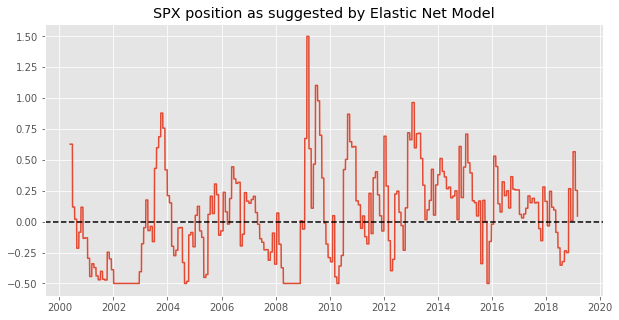

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(df_preds_re['position'])
plt.title('SPX position as suggested by Elastic Net Model')
plt.axhline(0, linestyle='--', color='k')
plt.show()

## Evaluating Portfolio

In [76]:
df_eval = df_preds_re.join(all_spx).dropna()

df_eval['buy_hold'] = np.exp(df_eval['SPX'].cumsum())
df_eval['strat_rt_daily'] = 1 + (df_eval['position'] * (np.exp(df_eval['SPX']) - 1))
df_eval['strat_rti'] = df_eval['strat_rt_daily'].cumprod()

df_eval.head()

,position,SPX,buy_hold,strat_rt_daily,strat_rti
2000-05-26,0.627349,-0.002537,0.997467,0.998411,0.998411
2000-05-30,0.627349,0.031733,1.029627,1.020227,1.018605
2000-05-31,0.627349,-0.001301,1.028288,0.999184,1.017774
2000-06-01,0.627349,0.019663,1.048707,1.012458,1.030454
2000-06-02,0.627349,0.019446,1.069300,1.012319,1.043148


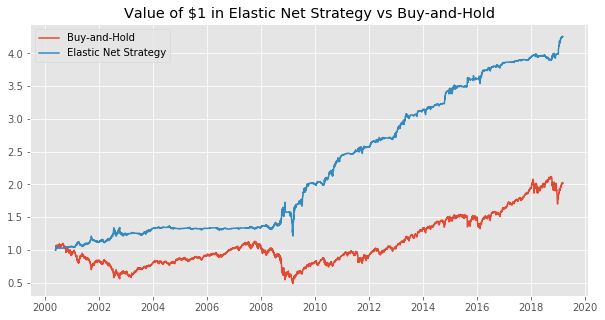

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(df_eval['buy_hold'], label='Buy-and-Hold')
plt.plot(df_eval['strat_rti'], label='Elastic Net Strategy')
plt.title('Value of $1 in Elastic Net Strategy vs Buy-and-Hold')
plt.legend()
plt.show()